In [1]:
#Libraries
import pandas as pd, numpy as np
import numpy as np
from datetime import datetime 
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
import seaborn as sns 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix 
from matplotlib import pyplot
import warnings # Suppress warnings because they are annoying warnings.filterwarnings('ignore') pd.set_option("display.max_columns", 101)

In [8]:
data = pd.read_csv("advertising.csv")

In [9]:
data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


In [10]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [11]:
#Explore columns
data.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

In [13]:
# Check missing data
print(data.isna().sum())

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


We have 255 missing values in Area Income. So let's plot it's ditribution to understand best way to impute data.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Area Income', ylabel='Density'>

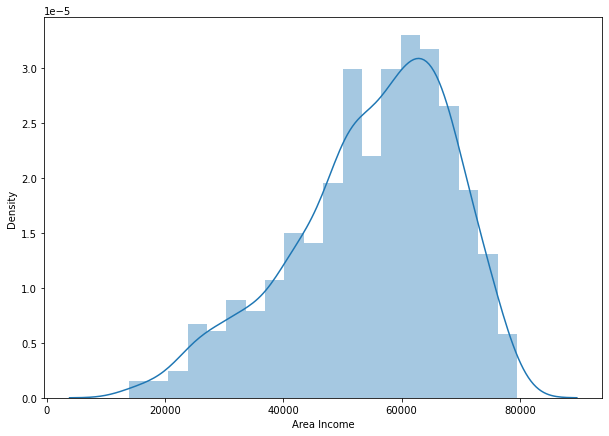

In [15]:
pyplot.figure(figsize=(10,7))
sns.distplot(data['Area Income'], bins = 20, kde=True, hist_kws=dict())

Since the plot is roughly normally distributed, imputing the values with median would be a good decision imputing both, test and training set with their respective median values

In [20]:
# Impute missing data based on the distribution of Area Income
data['Area Income'] = data['Area Income'].fillna(value = data['Area Income'].median)
print(data.isna().sum())

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


There are no more missing values in either dataset
Step 2: Since Ad Topic line is not usable as a categorical variable, we could convert it into a numercial variable by taking the lenght of the Ad topic line. Removing the data point is to be avoided and it's a good way to retain information in some form. Adding a new feature for both training and test dataset


In [25]:
# For Train Data
topic_len = []
for i in range(data.shape[0]): topic_len.append(len(data['Ad Topic Line'][i]))
print(len(topic_len))
data['topic_len'] = pd.DataFrame(topic_len)

#Extracting using timestamp
hour=[] 
month=[]
for i in data['Timestamp']:
    dt_object2 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S") 
    hour.append(dt_object2.hour) 
    month.append(dt_object2.month)
data['hour'] = pd.DataFrame(hour) 
data['month'] = pd.DataFrame(month) 
print(data.columns)

1000
Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'topic_len', 'hour', 'month'],
      dtype='object')


Lets Visualise some more features

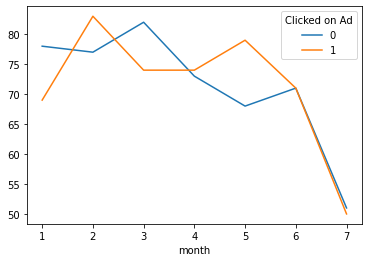

In [28]:
# Analysing monthly click data
series = data.groupby(['month','Clicked on Ad'])['Clicked on Ad'].count().unstack() 
series.plot()
pyplot.show()

Data volume & Clicks remains roughly the same in most months

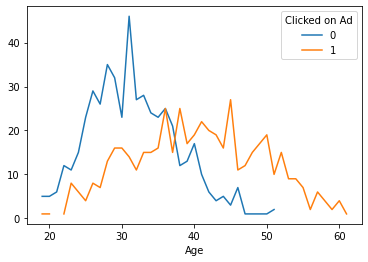

In [29]:
# Analysing Agewise click data
series = data.groupby(['Age','Clicked on Ad'])['Clicked on Ad'].count().unstack() 
series.plot()
pyplot.show()

Here we see a clear trend that older people(35+) are more likely to click as compared to younger(20-35) population

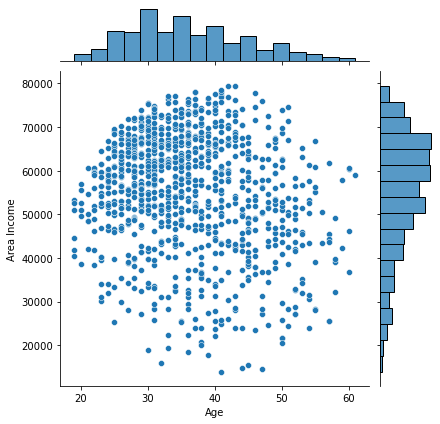

In [30]:
sns.jointplot(x='Age', y='Area Income', data= data)

We see that younger(20-35) have higher income (55K - 70K) as compared to older population. We see a straight line in the middle because we have imputed median values for missing values in this column.

Step 3: Prepare to model the data: Divide the dataset into Predictor and Response variables, where Response is if "Clicked" or not, as stated in the question. Doing this for both Training & test dataset

I am dropping ID since it have no numerical or categorical value add. It is just an idetifier.

I am dropping Timestamp since we have converted that information as hour and month, similarly for Ad topic line, it has been converted into length of topic


In [34]:
X = data.drop(['Ad Topic Line','Clicked on Ad','Timestamp',], axis = 1) 
y = data['Clicked on Ad']

Not converting Country and month into categorical variables, since while submitting the file test file have different month/country data and it conflicted with categorical columns. So I converted it into numerica categogical codes instead

In [41]:
X['Country'] = X['Country'].astype('category').cat.codes 
X['month'] = X['month'].astype('category').cat.codes 
X['City'] = X['City'].astype('category').cat.codes 

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   City                      1000 non-null   int16  
 5   Male                      1000 non-null   int64  
 6   Country                   1000 non-null   int16  
 7   topic_len                 1000 non-null   int64  
 8   hour                      1000 non-null   int64  
 9   month                     1000 non-null   int8   
dtypes: float64(3), int16(2), int64(4), int8(1)
memory usage: 59.7 KB


Dividing X_train into training and validation sets to check for accuracy. I am dividng it into 30(validation) - 70(train) set ratio

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 872)

Scaling the dataset since variables vary a lot in scale, eg: Area income Vs. Gender. Using Standard Scalar to scale

In [44]:
#scaling values
ss = StandardScaler()
X_train = ss.fit_transform(X_train) 
X_valid = ss.fit_transform(X_valid)

To optimise the model, using gridsearchCV to perform cross validation to get the best results
Defining the classifier and the parameters


In [48]:
clf = Pipeline([('scalar', StandardScaler()),('l1', LogisticRegression(penalty = 'l2', solver = "newton-cg", random_state = 872))])

param_grid = [{"l1__C" : np.logspace(-10,10,30)}]

log_reg = GridSearchCV(clf, param_grid, cv = 3) 
log_reg.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('l1',
                                        LogisticRegression(random_state=872,
                                                           solver='newton-cg'))]),
             param_grid=[{'l1__C': array([1.00000000e-10, 4.89390092e-10, 2.39502662e-09, 1.17210230e-08,
       5.73615251e-08, 2.80721620e-07, 1.37382380e-06, 6.72335754e-06,
       3.29034456e-05, 1.61026203e-04, 7.88046282e-04, 3.85662042e-03,
       1.88739182e-02, 9.23670857e-02, 4.52035366e-01, 2.21221629e+00,
       1.08263673e+01, 5.29831691e+01, 2.59294380e+02, 1.26896100e+03,
       6.21016942e+03, 3.03919538e+04, 1.48735211e+05, 7.27895384e+05,
       3.56224789e+06, 1.74332882e+07, 8.53167852e+07, 4.17531894e+08,
       2.04335972e+09, 1.00000000e+10])}])

Calculating the model accuracy and best parameters chosen by gridsearch

In [49]:
print(np.mean(log_reg.predict(X_valid) == y_valid)) 
best_params = log_reg.best_params_

0.9666666666666667


Calculating the model accuracy and best parameters chosen by gridsearch

In [58]:
lr = LogisticRegression(C = best_params['l1__C'], penalty = 'l2', solver = "newton-cg")
lr.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

LogisticRegression(C=0.018873918221350997, solver='newton-cg')

Looking at the model coefficients

In [59]:
print(pd.DataFrame(zip(X.columns.values, lr.coef_[0])).values)

[['Daily Time Spent on Site' -0.1821807866614786]
 ['Age' 0.16348422802722043]
 ['Area Income' -0.0001261512576226903]
 ['Daily Internet Usage' -0.061315338888878156]
 ['City' -0.0011977152792144031]
 ['Male' -0.04080249086761387]
 ['Country' -0.0006348467276700272]
 ['topic_len' -0.012174449927683946]
 ['hour' -0.002650060602330617]
 ['month' 0.006206561574498472]]
